In [1]:
#Import the required packages and modules
import os
import urllib
import time
import numpy as np
import matplotlib.pyplot as plt
#import scipy
#from PIL import Image
#from keras.preprocessing.image import load_img
#from keras.preprocessing.image import img_to_array
#from keras.preprocessing.image import array_to_img
import torch
import torchvision

In [3]:

def download_file(url, filename):
    """
    A function that downloads the data file from a URL
    Parameters
    ----------
    url : string
        url where the file to download is located
    filename : string
        location where to save the file
    reporthook : function
        callback to display the download progress
    """
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url, filename, reporthook)

def reporthook(count, block_size, total_size):
    """
    A function that displays the status and speed of the download
    """

    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = int(progress_size / (1024 * duration + 0.0001))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\r...%d%%, %d MB, %d KB/s, %d seconds passed" %
                     (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()

In [ ]:
name = 'Krishna'
download_file(f'https://zenodo.org/record/7339649/files/data_{name}.npz?download=1','data.npz')


#LOADING THE DATA

In [4]:
npz = np.load('/content/drive/MyDrive/Final exam assignment/data1.npz')


The Data file contains three NumPy arrays

In [5]:
training_feat = npz['training_feat']
training_true = npz['training_true']
validation_feat = npz['validation_feat']


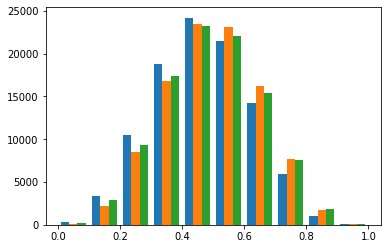

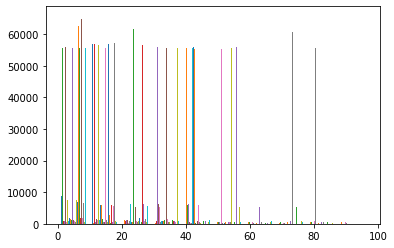

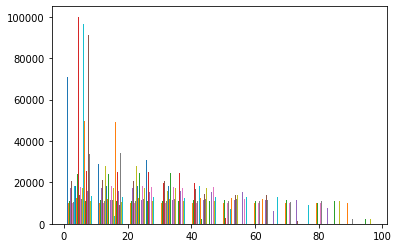

In [6]:
plt.hist(training_true)
plt.show()
plt.hist(validation_feat)
plt.show()
plt.hist(training_feat)
plt.show()

In [9]:
#Manually scaled the training features between (0,1). Regression values already between (0,1)
scaled_training_feat = (training_feat-np.min(training_feat))/(np.max(training_feat)-np.min(training_feat))
scaled_valid_feat = (validation_feat-np.min(validation_feat))/(np.max(validation_feat)-np.min(validation_feat))

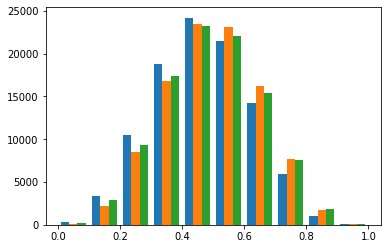

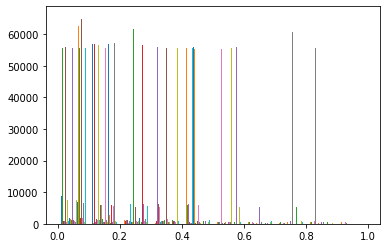

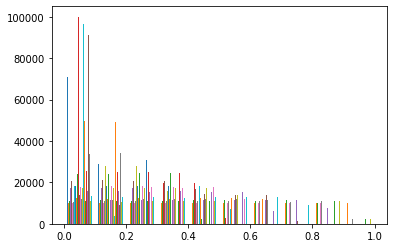

In [10]:
plt.hist(training_true)
plt.show()
plt.hist(scaled_valid_feat)
plt.show()
plt.hist(scaled_training_feat)
plt.show()

#BUILDING THE DATASET

In [11]:
class Dataset(torch.utils.data.Dataset):
  '''Dataset Class to store the samples and their corresponding labels,
  and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.
  '''

  def __init__(self, X: np.ndarray, y: np.ndarray, device = 'cuda') -> None:

    # need to convert float64 to float32 else
    # will get the following error
    # RuntimeError: expected scalar type Double but found Float
    self.X = torch.tensor(X,dtype=torch.float32).to(device)
    self.y = torch.tensor(y,dtype=torch.float32).to(device)
    self.len = len(X)

  def __getitem__(self, index: int) -> tuple:
    return (self.X[index],self.y[index])

  def __len__(self) -> int:
    return self.len

#TRAIN-TEST SPLIT

In [12]:
dataset = Dataset(scaled_training_feat,training_true)


In [13]:
train_dataset,test_dataset = torch.utils.data.dataset.random_split(dataset,[int(0.66 * len(dataset)), len(dataset) - int(0.66 * len(dataset))])


#BUILDING THE DATALOADER

In [14]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=64,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=64,shuffle=True)


#BUILDING A NEURAL NETWORK

In [15]:
class Neural_Network(torch.nn.Module):
  ''' Regression Model
  ''' 

  # note, you can ignore the `:int` and `-> None` this is just more advanced doctring syntax
  def __init__(self, input_dim: int, hidden_dim: int, output_dim: int) -> None:
      super(Neural_Network, self).__init__()
      self.input_layer = torch.nn.Linear(in_features=input_dim,out_features=hidden_dim,bias=False)
      self.relu_input_layer = torch.nn.ReLU()
      self.hidden_layer1 = torch.nn.Linear(in_features=hidden_dim,out_features=hidden_dim,bias=False)
      self.relu_h1 = torch.nn.ReLU()
      self.hidden_layer2 = torch.nn.Linear(in_features=hidden_dim,out_features=hidden_dim,bias=False)
      self.relu_h2 = torch.nn.ReLU()
      self.output_layer = torch.nn.Linear(in_features=hidden_dim,out_features=output_dim,bias=False)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
      # In this part you should build a model that returns the 3 outputs of the regression
      # Type your code here
      output = self.relu_input_layer(self.input_layer(x))
      output = self.relu_h1(self.hidden_layer1(output))
      output = self.relu_h2(self.hidden_layer2(output))
      output = self.output_layer(output)
      return output

#INSTANTIATE THE MODEL

In [16]:
input_dim = 30
hidden_layers_dim = 50
output_dim = 3
model = Neural_Network(input_dim=input_dim,hidden_dim = hidden_layers_dim,output_dim=output_dim).to(device="cuda")
print(model)

Neural_Network(
  (input_layer): Linear(in_features=30, out_features=50, bias=False)
  (relu_input_layer): ReLU()
  (hidden_layer1): Linear(in_features=50, out_features=50, bias=False)
  (relu_h1): ReLU()
  (hidden_layer2): Linear(in_features=50, out_features=50, bias=False)
  (relu_h2): ReLU()
  (output_layer): Linear(in_features=50, out_features=3, bias=False)
)


In [17]:
#Loss and optimizer functions
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)


#TRAIN THE MODEL

In [18]:
num_epochs = 20
all_losses = []
for e in range(num_epochs):
    batch_losses = []

    for ix, (X, y) in enumerate(train_dataloader):

        _X = torch.autograd.Variable(X).float()
        _y = torch.autograd.Variable(y).float()

        #Forward pass

        preds = model(_X)
        loss = loss_func(preds, _y)

        #backward pass

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.data)
        all_losses.append(loss.data)

        

    batch_mse = torch.mean(torch.stack(batch_losses))

    if e % 1 == 0:
        print("Epoch [{}/{}], Batch loss: {}".format(e, num_epochs, batch_mse))


Epoch [0/20], Batch loss: 0.12635353207588196
Epoch [1/20], Batch loss: 0.020683085545897484
Epoch [2/20], Batch loss: 0.016667025163769722
Epoch [3/20], Batch loss: 0.012249327264726162
Epoch [4/20], Batch loss: 0.008582539856433868
Epoch [5/20], Batch loss: 0.007326253689825535
Epoch [6/20], Batch loss: 0.006936956662684679
Epoch [7/20], Batch loss: 0.006773734465241432
Epoch [8/20], Batch loss: 0.0066995322704315186
Epoch [9/20], Batch loss: 0.006664440035820007
Epoch [10/20], Batch loss: 0.006646082270890474
Epoch [11/20], Batch loss: 0.00663605984300375
Epoch [12/20], Batch loss: 0.006618673447519541
Epoch [13/20], Batch loss: 0.006604339927434921
Epoch [14/20], Batch loss: 0.006585841067135334
Epoch [15/20], Batch loss: 0.006561701651662588
Epoch [16/20], Batch loss: 0.006535636261105537
Epoch [17/20], Batch loss: 0.0064954208210110664
Epoch [18/20], Batch loss: 0.006452145520597696
Epoch [19/20], Batch loss: 0.006393279414623976


#VALIDATING THE MODEL

In [19]:
with torch.no_grad():
  test_batch_losses = []
  for X, y in test_dataloader:
    _X = torch.autograd.Variable(X).float()
    _y = torch.autograd.Variable(y).float()

    test_loss = torch.tensor(0)
    #Get predictions on test set
    test_preds = model(_X)
    test_loss = loss_func(test_preds,_y)

    test_batch_losses.append(test_loss.data)
  print("Test Batch loss: {}".format(torch.mean(torch.stack(test_batch_losses))))


Test Batch loss: 0.006354453042149544


**Question: Is your model overfitting or not? How do you know? (3 points)**

We can observe that the final loss for the training epochs was ~0.00639 while the test batch loss was ~0.00635. This shows that the model performs similarly well on the testing split and does not lose predictive performance when predicting testing data



#CRACKING MY CODE

In [20]:
scaled_valid_feat = (validation_feat-np.min(validation_feat))/(np.max(validation_feat)-np.min(validation_feat))
valid_tensor = torch.tensor(scaled_valid_feat,dtype=torch.float32).to('cuda')
validation_dataloader = torch.utils.data.DataLoader(dataset=valid_tensor,batch_size=64)

with torch.no_grad():
  prediction_list = []
  for X in validation_dataloader:
    _X = torch.autograd.Variable(X).float()

    valid_preds = model(_X)
    prediction_list.append(valid_preds.cpu())


#REVEALING MY CODE

In [21]:
code_image_np = torch.cat(prediction_list).detach().cpu().numpy().reshape(256,256,3)


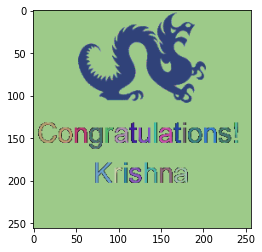

In [22]:
plt.imshow(code_image_np)